In [1]:
import numpy as np
import gzip
import struct

def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack(">HBB", f.read(4))
        shape = tuple(struct.unpack(">I", f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)


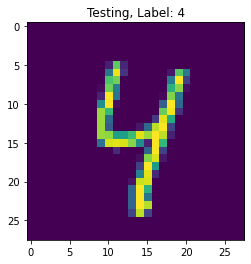

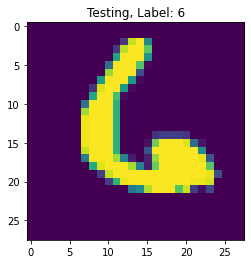

In [2]:
### Data Import ###

import matplotlib.pyplot as plt
import os

NUM_TRAIN_SAMPLES = 60000
NUM_TEST_SAMPLES = 10000

# Assume that files are in current directory
TRAIN_IMAGE_PATH = "train-images-idx3-ubyte.gz"
TRAIN_LABEL_PATH = "train-labels-idx1-ubyte.gz"
TEST_IMAGE_PATH = "t10k-images-idx3-ubyte.gz"
TEST_LABEL_PATH = "t10k-labels-idx1-ubyte.gz"

training_images = read_idx(TRAIN_IMAGE_PATH)
training_labels = read_idx(TRAIN_LABEL_PATH)
testing_images = read_idx(TEST_IMAGE_PATH)
testing_labels = read_idx(TEST_LABEL_PATH)

def print_image_label_pairs(image_dataset, label_dataset, title):
    # Vector to pick random image/label pairs
    random_samples = np.random.randint(0, len(image_dataset), size=2)
    handle = 0  # Generic handle so multiple figs can be created
    
    for idx in random_samples:
        plt.figure(handle)
        handle += 1
        plt.imshow(image_dataset[idx,:,:])
        plt.title("{}, Label: {}".format(title, label_dataset[idx]))

print_image_label_pairs(training_images, training_labels, "Training")
print_image_label_pairs(testing_images, testing_labels, "Testing")


Using the `read_idx()` method to read in raw gzip files. Multiple images are plotted to show image corresponds to proper label.

1.0 0.0
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

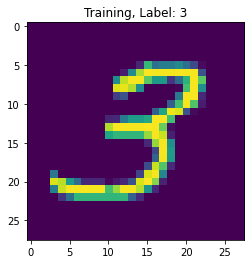

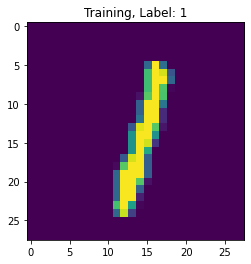

In [13]:
### Normalize Pixels, Categorize Labels ###

def normalize_dataset(data_array):
    a = data_array.min()
    b = data_array.max()
    return (data_array - a)/(b - a)

train_img_norm = normalize_dataset(training_images)
train_label_cat = [int(string_num) for string_num in training_labels]
test_img_norm = normalize_dataset(testing_images)
test_label_cat = [int(string_num) for string_num in testing_labels]

# Make sure data still looks good
print_image_label_pairs(train_img_norm, training_labels, "Training")
# Make sure min and max are within bounds
print(train_img_norm.max(), train_img_norm.min())

### Flatten Data ###
#print(train_img_norm[6,:,:])
print(train_img_norm[6,:,:].reshape(-1))
train_img_norm_flat = np.array([train_img_norm[idx,:,:].reshape(-1) for idx in range(len(train_img_norm))])



#train_img_norm_flat = train_img_norm.reshape((NUM_TRAIN_SAMPLES, 28*28))
#test_img_norm_flat = test_img_norm.reshape(NUM_TEST_SAMPLES, 28*28)

Data was normalized using [this function](https://stackoverflow.com/questions/65029540/normalize-dataset-in-python). To confirm that data is properly normalized, the min an max values are inspected (to make sure they're between 1.0 and 0) and the data is plotted for visual confirmation. 
Label data is categorized by converting the sting value for each number into an int value.

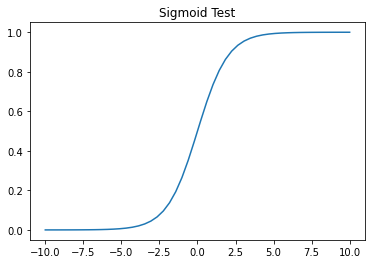

In [4]:
### Feed Forward, Inits ###

# Inits
TEST_SIGMOID = True
np.random.seed(695)
NUM_LAYER_0_NODES = 784
NUM_LAYER_1_NODES = 127
NUM_LAYER_2_NODES = 63
NUM_OUTLAYER_NODES = 10

# Init weight vectors randomly
layer_0_weights = np.random.rand(NUM_LAYER_0_NODES, NUM_LAYER_1_NODES)
layer_0_bias = np.random.rand(NUM_LAYER_0_NODES, NUM_LAYER_1_NODES)
layer_1_weights = np.random.rand(NUM_LAYER_1_NODES, NUM_LAYER_2_NODES)
layer_1_bias = np.random.rand(NUM_LAYER_1_NODES, NUM_LAYER_2_NODES)
layer_2_weights = np.random.rand(NUM_LAYER_2_NODES, NUM_OUTLAYER_NODES)
layer_2_bias = np.random.rand(NUM_LAYER_2_NODES, NUM_OUTLAYER_NODES)

# Sigmoid Function def
def sigmoid(x):
    return 1/(1+np.exp(-x))

# Test Sigmoid Function
if TEST_SIGMOID:
    test_vec = np.linspace(-10,10)
    plt.plot(test_vec, sigmoid(test_vec))
    plt.title("Sigmoid Test")


In [5]:
def feed_forward_step(input_vec, weight_vec, bias):
    return sigmoid(np.sum((input_vec * weight_vec) + bias))

def run_feed_forward(training_vec, weight_vec, bias_vec):
    next_layer = []
    num_rows, num_cols = weight_vec.shape
    for idx in range(num_cols):
        next_layer.append(feed_forward_step(training_vec, weight_vec[:,idx], bias_vec[:,idx]))
    return np.array(next_layer)

out_values = []
for idx in range(25):
    H1_values = run_feed_forward(train_img_norm_flat[idx,:], layer_0_weights, layer_0_bias)
    H2_values = run_feed_forward(H1_values, layer_1_weights, layer_1_bias)
    out_values.append(run_feed_forward(H2_values, layer_2_weights, layer_2_bias))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
def catergorical_crossentropy(y_true, y_pred):
    n_samples = y_true.shape[0]
    y_pred_clipped = np.clip(y_pred, 1e-12, 1-1e-12)
    return -np.sum(y_true * np.log(y_pred_clipped))/n_samples
    